# Seasonal Sea Surface Temperature Anomalies for SOE
Laura Gruenburg
laura.gruenburg@noaa.gov
10/31/2024

In [42]:
# import relevant packages
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import regionmask
import READ_EDAB_Utilities_py as reupy
import pandas as pn

In [11]:
# load the data
tos = xr.open_dataset('ocean_daily.19930101-20191231.tos.nc')

In [157]:
tos

<xarray.Dataset>
Dimensions:  (time: 9861, lon: 774, lat: 844)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 ... 2019-12-31T12:00:00
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
  * lat      (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes:
    NumFilesInSet:  1
    title:          NWA12_MOM6_v1.0
    grid_type:      regular
    grid_tile:      N/A
    history:        Derived and written at NOAA Physical Science Laboratory
    contact:        chia-wei.hsu@noaa.gov
    dataset:        regional mom6 regrid

In [13]:
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')

In [14]:
# Specify the EPUs
mab = epu[epu.EPU == 'MAB']
gom = epu[epu.EPU == 'GOM']
gb = epu[epu.EPU == 'GB']

In [23]:
tos_cropped = tos.sel(lat = slice(28, 48), lon = slice(280, 300))

In [25]:
mab_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])

In [34]:
# Subset data to only within each EPU and average in space and resample to quarterly
mab_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', mab).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gom_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', gom).resample(time = 'QS-JAN').mean().mean(['lat','lon'])
gb_tos = reupy.crop_nd(tos_cropped, 'lon', 'lat', gb).resample(time = 'QS-JAN').mean().mean(['lat','lon'])

In [35]:
# Create climatologies
mab_tos_clim = mab_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gom_tos_clim = gom_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')
gb_tos_clim = gb_tos.sel(time = slice('1993-01-01','2010-12-31')).groupby('time.month').mean('time')

In [39]:
mab_tos_anom = mab_tos.groupby('time.month') - mab_tos_clim
gom_tos_anom = gom_tos.groupby('time.month') - gom_tos_clim
gb_tos_anom = gb_tos.groupby('time.month') - gb_tos_clim

In [47]:
df_mab = pn.DataFrame({'Time': pn.to_datetime(mab_tos_anom.time).year,
                      'Season': mab_tos_anom.month,
                      'Value': mab_tos_anom.tos,
                      'EPU': 'MAB',
                      'Unit': 'degrees C'})

In [49]:
df_gom = pn.DataFrame({'Time': pn.to_datetime(gom_tos_anom.time).year,
                      'Season': gom_tos_anom.month,
                      'Value': gom_tos_anom.tos,
                      'EPU': 'GOM',
                      'Unit': 'degrees C'})

In [50]:
df_gb = pn.DataFrame({'Time': pn.to_datetime(gb_tos_anom.time).year,
                      'Season': gb_tos_anom.month,
                      'Value': gb_tos_anom.tos,
                      'EPU': 'GB',
                      'Unit': 'degrees C'})

In [152]:
TOS = pn.concat([df_mab,df_gom,df_gb]).reset_index(drop = True)

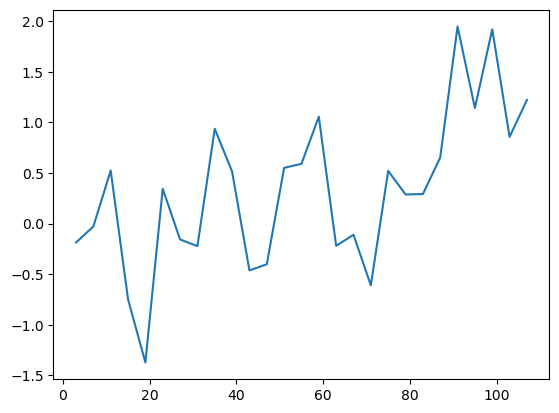

In [177]:
plt.plot(TOS[(TOS.EPU == 'MAB') & (TOS.Season == 10)].Value)

'NEUS_LME'

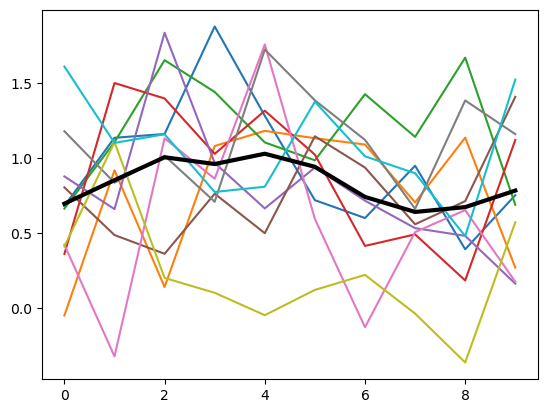

In [172]:

epu_titles = ['MAB_EPU', 'GOM_EPU', 'SS_EPU', 'GB_EPU', 'NEUS_LME', 'SS_LME']
epu_values = [4, 5, 0, 1, 2, 3]
n_epus = len(epu_titles)

for i in range(n_epus):
        hind_i = tos_forecast.sel(epu=epu_values[i])
        epu_name = epu_titles[epu_values[i]]
    
hind_i  = tos_forecast.sel(epu=epu_values[0])
epu_name = epu_titles[epu_values[0]]
plt.plot(hind_i.tos[:,57,:])
plt.plot(np.nanmean(hind_i.tos[:,57,:],1), c = 'k', linewidth = 3)
epu_name

In [155]:
TOS.to_csv('tos_hindcast.csv')

In [120]:
tos_forecast = xr.open_dataset('nwa12_hind_epu_annual_tos.nc')

In [142]:
tos_data = tos_forecast.tos[0,:,57,0]
tos_forecast_mab = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'MAB',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[0,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'MAB',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_mab = pn.concat([tos_forecast_mab, tos_df])

tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Val': np.nanmean(tos_forecast.tos[0,:,57,:],1),
                         'EPU': 'MAB',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_mab = pn.concat([tos_forecast_mab, tos_mean])

In [145]:
tos_data = tos_forecast.tos[1,:,57,0]
tos_forecast_gom = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'GOM',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[1,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'GOM',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_gom = pn.concat([tos_forecast_gom, tos_df])


tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Val': np.nanmean(tos_forecast.tos[1,:,57,:],1),
                         'EPU': 'GOM',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_gom = pn.concat([tos_forecast_gom, tos_mean])

In [146]:
tos_data = tos_forecast.tos[3,:,57,0]
tos_forecast_gb = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'GB',
              'e_member': 1,
              'Unit': 'degrees C'})

for i in range(1,10):
    tos_data = tos_forecast.tos[3,:,57,i]
    tos_df = pn.DataFrame({'Time': np.arange(2023, 2033),
              'Val': tos_data.values,
              'EPU': 'GB',
              'e_member': i+1,
              'Unit': 'degrees C'})
    tos_forecast_gb = pn.concat([tos_forecast_gb, tos_df])

tos_mean = pn.DataFrame({'Time': np.arange(2023, 2033),
                         'Val': np.nanmean(tos_forecast.tos[3,:,57,:],1),
                         'EPU': 'GB',
                         'e_member': 'Ensemble Mean',
                         'Unit': 'degrees C'})
tos_forecast_gb = pn.concat([tos_forecast_gb, tos_mean])

In [149]:
tos_10forecast = pn.concat([tos_forecast_mab, tos_forecast_gom, tos_forecast_gb]).reset_index(drop = True)

In [150]:
tos_10forecast

,Time,Val,EPU,e_member,Unit
0,2023,0.585255,MAB,1,degrees C
1,2024,0.899135,MAB,1,degrees C
2,2025,1.073020,MAB,1,degrees C
3,2026,1.833349,MAB,1,degrees C
4,2027,1.587018,MAB,1,degrees C
...,...,...,...,...,...
325,2028,0.760833,GB,Ensemble Mean,degrees C
326,2029,0.514280,GB,Ensemble Mean,degrees C
327,2030,0.333196,GB,Ensemble Mean,degrees C
328,2031,0.359613,GB,Ensemble Mean,degrees C


In [154]:
tos_10forecast.to_csv('tos_10forecast.csv')

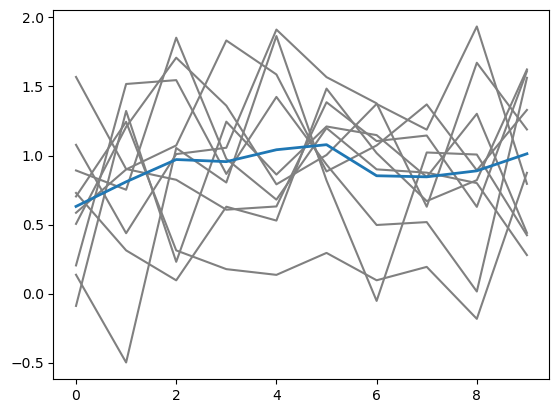

In [158]:
import numpy as np
i = 0
plt.plot(tos_10.tos[i,:,57,0],c='grey')
plt.plot(tos_10.tos[i,:,57,1],c='grey')
plt.plot(tos_10.tos[i,:,57,2],c='grey')
plt.plot(tos_10.tos[i,:,57,3],c='grey')
plt.plot(tos_10.tos[i,:,57,4],c='grey')
plt.plot(tos_10.tos[i,:,57,5],c='grey')
plt.plot(tos_10.tos[i,:,57,6],c='grey')
plt.plot(tos_10.tos[i,:,57,7],c='grey')
plt.plot(tos_10.tos[i,:,57,8],c='grey')
plt.plot(tos_10.tos[i,:,57,9],c='grey')
plt.plot(np.nanmean(tos_10.tos[i,:,57,:],1), linewidth = 2)
#plt.plot(np.nanmean(tos_10.tos[5,:,57,:],1))

In [ ]:
#0 - mab
#1 - gom
#2 - ss
#3 - gb
#4 - neus
#5 - ss-lme